In [1]:
from ValueIteration import value_iteration
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# Implementing Value Iteration to solve 3-echelon inventory optimisation MDPs

## Centralised system

### No lead times

#### Set up data structures

In [2]:
# Function to create state space
def create_state_space(capacity, increment, n_ech=2):
    ''' Creates a set as the state space for an n-echelon problem 
    with format (x1, ..., xn) where xj is the inventory level at site j '''

    # Possible inventory levels at each site
    IL = set(int(x) for x in np.arange(-capacity, capacity+1, increment))

    # Possible set of sets
    S = sorted(set(il_pair for il_pair in itertools.product(IL, repeat=n_ech) if il_pair[1] >= 0))

    # Dictionary containing indices for each state (for value iteration)
    state_idx = {s: i for i, s in enumerate(S)}
    
    return S, state_idx

def create_action_space(capacity, increment, n_ech=2):
    ''' Creates a set as the action space for an n-echelon inventory problem
    with format (q1, ..., qn) where qj is the quantity ordered by site j 
    from site j+1 '''

    # The maximum order quantity at each site is half the capacity of the site
    order_set = set(int(x) for x in np.arange(0, math.ceil(capacity/2)+1, increment))
    
    # Possible actions
    A = sorted(set(order_pair for order_pair in itertools.product(order_set, repeat=n_ech)))

    # Dictionary containing indices for each action (for value iteration)
    action_idx = {a: i for i, a in enumerate(A)}

    return A, action_idx



def create_P_c0(S, A, state_idx, action_idx, demand_distribution, capacity):
    ''' 
    Creates an array containing transition probabilities from s to s' under a
    for a centralised multi-echelon serial system without lead times 
    '''

    def prob_trans(s, a, sp):
        ''' Calculates transition probability from s to s' under action a'''
        prob = 0

        # check next inventory level for warehouse
        s_next_W = s[1] + a[1] - a[0] # default next state value
        if s_next_W != sp[1]: # inventory transition at W
            return prob
        
        if a[0] > s[1]: # check DC to W order constraint is violated
            return prob
        
        # check next inventory level for DC
        for d in demand_distribution.keys():
            s_next_DC = s[0] + a[0] - d
            if - capacity < s_next_DC < capacity: # non truncated state
                if sp == (s_next_DC, s_next_W):
                    prob = demand_distribution.get(d, 0)
                    return prob

            elif s_next_DC >= capacity: # truncated state above capacity
                if sp == (capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + a[0] - dem >= capacity)
                    return prob
                
            elif s_next_DC <= -capacity: # truncated state below backlog limit
                if sp == (-capacity, s_next_W):
                    prob = sum(demand_distribution[dem] for dem in demand_distribution if s[0] + a[0] - dem <= -capacity)
                    return prob
            
        return prob
    
    # array to store transition probabilities for all combinations of s, a, s'
    P_array = np.zeros((len(S), len(A), len(S)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            for sp in S: # for each new state s'
                sp_idx = state_idx[sp]
                # calculate and store probability of transitioning to s' from s under a
                P_array[s_idx, a_idx, sp_idx] = prob_trans(s, a, sp) 
    
    return P_array



        
def create_R_c0(S, A, state_idx, action_idx, demand_distribution, hold_costs, backlog_cost):
    ''' 
    Creates an array containing reward obtained under action a chosen at 
    state s for a centralised multi-echelon serial system without lead times.
    '''

    def cost_function(s, a):
        ''' Calculates the cost incurred if action a is taken at state s. '''
        # Costs at warehouse: holding cost (hc)
        hc_w = hold_costs[1]*max(s[1] + a[1] - a[0], 0)
        warehouse_cost = hc_w

        # Costs at DC: holding cost (hc) and backlog cost (bc)
        hc_dc = hold_costs[0]*sum(max(s[0] + a[0] - dt, 0)*prob for dt, prob in demand_distribution.items())
        bc_dc = backlog_cost*sum(max(dt - s[0] - a[0], 0)*prob for dt, prob in demand_distribution.items())
        dc_cost = hc_dc + bc_dc

        return warehouse_cost + dc_cost
    
    R_array = np.zeros((len(S), len(A)))

    for s in S: # for each state s
        s_idx = state_idx[s]
        for a in A: # for each action a
            a_idx = action_idx[a]
            R_array[s_idx, a_idx] = cost_function(s, a) # calculate reward for taking action a at state s

    return R_array



def c0_value_update_func(state_idx, action_idx, capacity):
    def bellman_eq_2c0(s, S, A, P, R, gamma, Vk):
        ''' Calculates the values from taking each action at state s '''
        s_idx = state_idx[s]
        # ordering decisions should ensure that site capacity is not exceeded and DC orders at most on-hand stock of warehouse
        values = dict((a, 0) for a in A if s[0]+a[0] <= capacity and s[1]+a[1] <= capacity and a[0] <= s[1])
        # print("s:", s, "possible orders:", values.keys())
        if not values: # if there are no possible ordering decisions, then no units need to be ordered
            values = {(0, 0): 0}
        
        for a in values.keys():
            a_idx = action_idx[a]
            values[a] = R[s_idx, a_idx] + gamma*sum([P[s_idx, a_idx, state_idx[sp]]*Vk[sp] for sp in S])
        return values
    
    return bellman_eq_2c0


In [3]:
# Solving the centralised 3-echelon MDP
capacity = 1000
increment = 100

S, state_idx = create_state_space(capacity, increment)        # state space
A, action_idx = create_action_space(capacity, increment)      # action space
demand_dist = {0: 0.2, 100: 0.6, 200: 0.2}                    # retailer demand distribution
h = [1, 0.5]                                                  # holding cost at DC, W
cb = 100                                                      # backlog penalty cost at DC
P = create_P_c0(S, A, state_idx, action_idx, demand_dist, capacity)
R = create_R_c0(S, A, state_idx, action_idx, demand_dist, hold_costs=h, backlog_cost=cb)
V_init = dict([(s, 0) for s in S])
gamma = 0.999
bellman_eq_c0 = c0_value_update_func(state_idx, action_idx, capacity)

# Run and store results from value iteration
c0_results = value_iteration(S, A, P, R, gamma, max_iterations=100, 
                             bellman_eq=bellman_eq_c0, V_init=V_init, theta=1e-7)
c0_optimal_policy = c0_results["optimal_policy"]
c0_cost_function = c0_results["value_function"]



In [4]:
# Code to check that transition probabilities add up to 1 for each (s, a) pair
count = 0
for s in S:
    for a in A:
        if a[0] <= s[1] and a[0] + s[0] <= capacity and a[1] + s[1] <= capacity:
            # print(s, a, R[state_idx[s], action_idx[a]])
            if sum(P[state_idx[s], action_idx[a], state_idx[sp]] for sp in S) != 1:
                count += 1
                print(s, a, sum(P[state_idx[s], action_idx[a], state_idx[sp]] for sp in S))
print(count, "out of", len(S)*len(A))

0 out of 8316


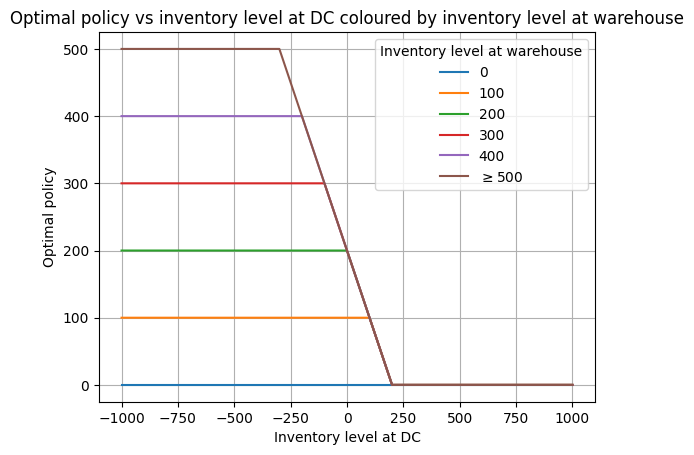

In [5]:

DC_il_pol = dict((x1, [[], []]) for (x1, x2) in S) # store W IL and W optimal policy for each DC IL
W_il_pol = dict((x2, [[], []]) for (x1, x2) in S)  # store DC IL and DC optimal policy for each W IL
for (x1, x2), (q1, q2) in c0_optimal_policy.items():
    DC_il_pol[x1][0].append(x2)
    DC_il_pol[x1][1].append(q2)
    W_il_pol[x2][0].append(x1)
    W_il_pol[x2][1].append(q1)


# Pick a colormap (e.g., 'viridis') and map keys to colors
cmap = plt.get_cmap('tab20')
keys = sorted(W_il_pol.keys())
colors = cmap([i / (len(keys) - 1) for i in range(len(keys))])

for il, color in zip(keys, colors):
    if il <= 500:
        plt.plot(W_il_pol[il][0], W_il_pol[il][1], label=il if il < 500 else rf"$\geq 500$", color=color)

plt.xlabel("Inventory level at DC")
plt.ylabel("Optimal policy")
plt.title("Optimal policy vs inventory level at DC coloured by inventory level at warehouse")
plt.legend(title="Inventory level at warehouse")
plt.grid()
plt.show() 

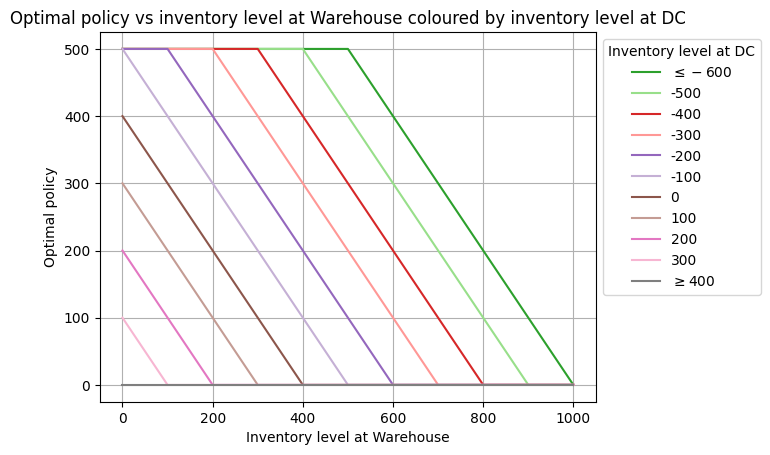

In [6]:
# Pick a colormap (e.g., 'viridis') and map keys to colors
cmap = plt.get_cmap('tab20')
keys = sorted(DC_il_pol.keys())
colors = cmap([i / (len(keys) - 1) for i in range(len(keys))])

for il, color in zip(keys, colors):
    if -600 <= il <= 400:
        label = il if -600 < il < 400 else rf"$\geq 400$" if il >= 400 else rf"$\leq -600$"
        plt.plot(DC_il_pol[il][0], DC_il_pol[il][1], label=label, color=color)

plt.xlabel("Inventory level at Warehouse")
plt.ylabel("Optimal policy")
plt.title("Optimal policy vs inventory level at Warehouse coloured by inventory level at DC")
plt.legend(title="Inventory level at DC", bbox_to_anchor=(1, 1))
plt.grid()
plt.show() 

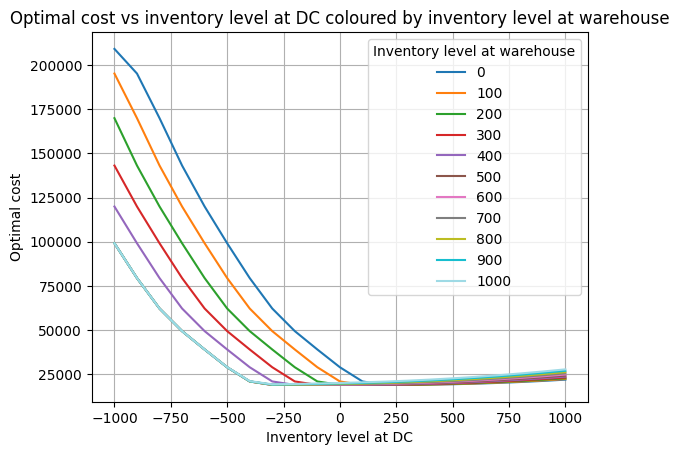

In [7]:
DC_il_cost = dict((x1, [[], []]) for (x1, x2) in S) # store W IL and W optimal policy for each DC IL
W_il_cost = dict((x2, [[], []]) for (x1, x2) in S)  # store DC IL and DC optimal policy for each W IL
for (x1, x2), cost in c0_cost_function.items():
    DC_il_cost[x1][0].append(x2)
    DC_il_cost[x1][1].append(cost)
    W_il_cost[x2][0].append(x1)
    W_il_cost[x2][1].append(cost)


# Pick a colormap (e.g., 'viridis') and map keys to colors
cmap = plt.get_cmap('tab20')
keys = sorted(W_il_cost.keys())
colors = cmap([i / (len(keys) - 1) for i in range(len(keys))])

for il, color in zip(keys, colors):
    # if il <= 500:
        plt.plot(W_il_cost[il][0], W_il_cost[il][1], label=il, color=color)

plt.xlabel("Inventory level at DC")
plt.ylabel("Optimal cost")
plt.title("Optimal cost vs inventory level at DC coloured by inventory level at warehouse")
plt.legend(title="Inventory level at warehouse")
plt.grid()
plt.show() 

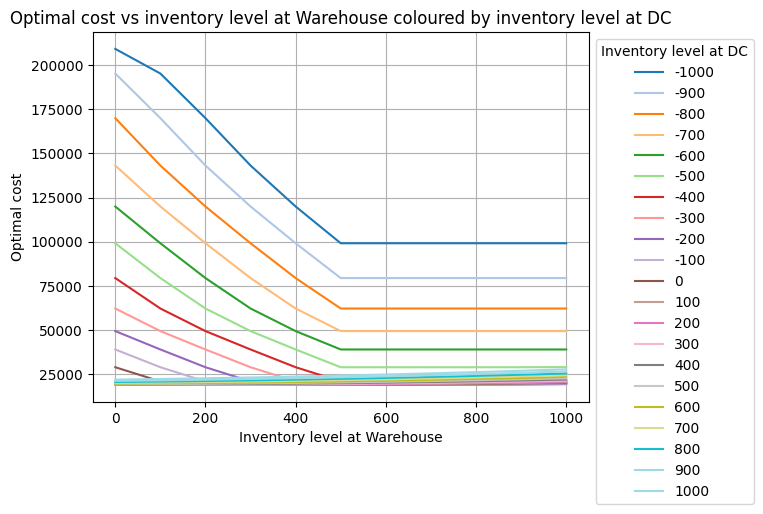

In [8]:
# Pick a colormap (e.g., 'viridis') and map keys to colors
cmap = plt.get_cmap('tab20')
keys = sorted(DC_il_cost.keys())
colors = cmap([i / (len(keys) - 1) for i in range(len(keys))])

for il, color in zip(keys, colors):
    # if -600 <= il <= 400:
        # label = il if -600 < il < 400 else rf"$\geq 400$" if il >= 400 else rf"$\leq -600$"
        plt.plot(DC_il_cost[il][0], DC_il_cost[il][1], label=il, color=color)

plt.xlabel("Inventory level at Warehouse")
plt.ylabel("Optimal cost")
plt.title("Optimal cost vs inventory level at Warehouse coloured by inventory level at DC")
plt.legend(title="Inventory level at DC", bbox_to_anchor=(1, 1))
plt.grid()
plt.show() 

In [ ]:
# # all policy info in lists
# all_dc_il = []
# all_dc_pol = []
# all_dc_cost = []
# all_w_il = []
# all_w_pol = []
# all_w_cost = []

# for il, pol in c0_optimal_policy.items():
#     all_dc_il.append(il[0])
#     all_w_il.append(il[1])
#     all_dc_pol.append(pol[0])
#     all_w_pol.append(pol[1])
#     all_dc_cost.append(c0_cost_function[il])
#     all_w_cost.append(c0_cost_function[il])

# fig, ax = plt.subplots()
# scatter = plt.scatter(all_dc_il, all_dc_pol, c=all_w_il, cmap="viridis")

# plt.colorbar(scatter, label="on-hand stock at W")
# plt.xlabel("Inventory level at DC")
# plt.ylabel("Optimal policy")
# plt.title("Optimal policy vs inventory level at DC coloured by inventory level at warehouse")
# plt.grid()
# plt.show() 

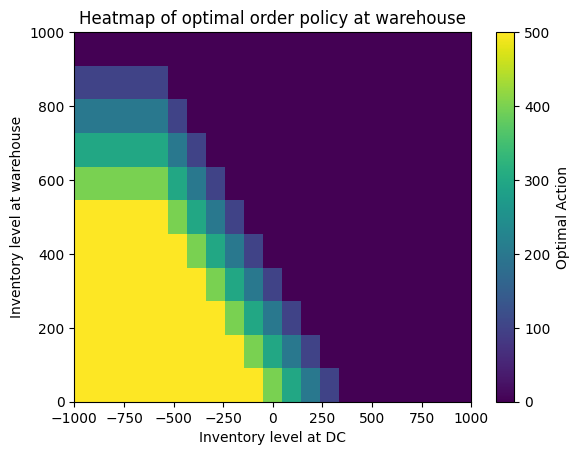

In [16]:
def generate_heatmap_2ech(optimal_dict, heatmap_type="cost"):
    # Get the inventory levels for each echelon from the optimal dictionary
    dc_il = sorted(set(key[0] for key in optimal_dict))
    w_il = sorted(set(key[1] for key in optimal_dict))

    grid = np.zeros((len(w_il), len(dc_il)))
    if heatmap_type == "cost":
        figure_title = "Heatmap of minimised total cost"
        for (x1, x2), cost in optimal_dict.items():
            grid[w_il.index(x2), dc_il.index(x1)] = cost

    else:
        figure_title = f"Heatmap of optimal order policy at {'DC' if heatmap_type == 'dc_policy' else 'warehouse'}"
        for (x1, x2), (pol1, pol2) in optimal_dict.items():
            grid[w_il.index(x2), dc_il.index(x1)] = pol1 if heatmap_type=="dc_policy" else pol2
    
    im = plt.imshow(grid, cmap="viridis", origin="lower", aspect="auto",
                    extent=[min(dc_il), max(dc_il), min(w_il), max(w_il)])
    plt.colorbar(im, 
                 label="Minimised Cost" if heatmap_type=="cost" else "Optimal Action")
    plt.xlabel("Inventory level at DC")
    plt.ylabel("Inventory level at warehouse")
    plt.title(figure_title)
    
    return im

generate_heatmap_2ech(c0_optimal_policy, heatmap_type="w_policy")
